##  고급 회기 실습 : 캐글 주택 가격 회기 분석

### 사용 데이터 
데이터 다운로드  
https:www.kaggle.com  
house 검색  
train.csv 파일 다운로드 받아서  
house_price.csv로 저장

---
house_price 데이터
- 79개의 변수로 구성
- 미국 아이오와 주의 에임즈(Ames) 지방의 주택 가격 정보 데이터

### 전체 회귀 분석 과정
1. 데이터 전처리 : Null, target 값 로그 변환, 원-핫 인코딩  
2. 선형 회귀 모델 : LinearRegression, Ridge, Lasso  
   (1) 학습/예측/평가   
   (2) 모델별 회귀 계수 시각화  
   (3) 교차 검증 수  
   (4) 하이퍼 파라미터 튜닝 후 재학습 / 예측 / 평가  
3. 피처 데이터 변환  
   (1) 왜곡도 / 피처 데이터 로그 변환 / 원-핫 인코딩  
   (2) 모델 학습/예측/평가   
   (3) 모델별 회귀 계수 시각화  
   (4) 이상치 처리  
   (5) 릿지 / 라쏘 모델 최적화 수행  
4. 회귀 트리 모델  : XGBoost와 LightGBM   
   (1) 학습/예측/평가   
   (2) 피처 중요도 시각화  
5. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
   -  릿지 모델(40%)과 라쏘 모델(60%) 혼합  
6. 스태킹 앙상블 모델을 통한 회귀 예측  
   - 스태킹 앙상블 모델  

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

### 1.  데이터 전처리
- Null 값 처리, target 값 로그 변환, 원-핫 인코딩   

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('../../data/house_price.csv')
# 가공 작업 중에 원본 데이터 필요
# 원본 데이터 유지하기 위해, 복사본으로 가공 작업 진행 
house_df = house_df_org.copy()
house_df.head()
house_df.tail()

# Target 값 : SalePrice (주택 가격) (마지막 칼럼)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


주요 피처들

- 1stFlrSF: First Floor square feet  
- 2ndFlrSF: Second floor square feet  
- GrLivArea: Above grade (ground) living area square feet      
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)  
- LotArea: Lot size in square feet      
- GarageArea: Size of garage in square feet      
- OverallQual: Rates the overall material and finish of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average  
       5	Average  
       4	Below Average  
       3	Fair  
       2	Poor  
       1	Very Poor	  
- OverallCond: Rates the overall condition of the house  
       10	Very Excellent  
       9	Excellent  
       8	Very Good  
       7	Good  
       6	Above Average	  
       5	Average  
       4	Below Average	  
       3	Fair  
       2	Poor  
       1	Very Poor  
- YearBuilt: Original construction date  
- Neighborhood: Physical locations within Ames city limits  
   Blmngtn  Bloomington Heights  
   Blueste  Bluestem  
   BrDale   Briardale  
   .....

- RoofMatl: Roof material  
	ClyTile	Clay or Tile  
	CompShg	Standard (Composite) Shingle  
	Membran	Membrane  
	Metal	Metal  
	.....

- RoofStyle: Type of roof  
	Flat	Flat  
	Gable	Gable  
	Gambrel	Gabrel (Barn)  
	.....

#### 데이터 확인

In [3]:
# 데이터 타입 확인
house_df.shape
house_df.dtypes.value_counts()

(1460, 81)

object     43
int64      35
float64     3
Name: count, dtype: int64

In [4]:
# Null 값 개수 및 피처 확인 
null_counts = house_df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)
        
# Alley, FireplaceQu, PoolQC, Fence, MiscFeature은 데이터에 비해 Null이 너무 많음

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

데이터 확인 결과
- 1460개의 레코드(행, 건), 81개의 피처로 구성
- 피처 타입 : 문자형(object), 숫자형(정수(int), 실수(float))
- Target을 제외한 80개의 피처 중 43개 문자형, 나머지 숫자형
- 데이터 양에 비해 Null 값이 많은 피처 존재
- 1,000개가 넘는 데이터가 Null 인 피처도 존재
- Null이 너무 많은 피처는 drop할 것임

### 회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인

<Axes: xlabel='SalePrice', ylabel='Density'>

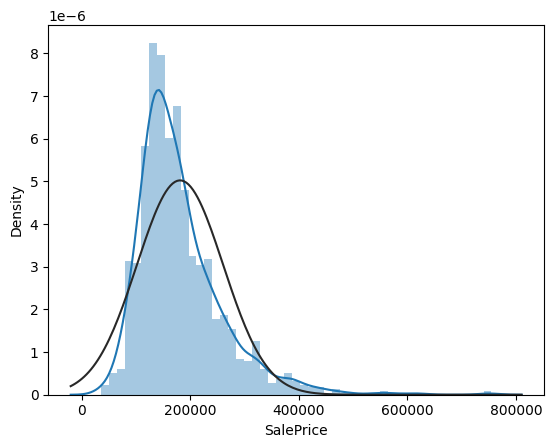

In [5]:
# 타깃값 SalePrice의 분포도 확인
from scipy.stats import norm #science python 의 통계 패키지의 정규분포와 비슷한지 확인
from scipy import stats

sns.distplot(house_df['SalePrice'], fit=stats.norm)
# 왼쪽으로 치우침


### 로그 변환 및 환원
- 정규 분포가 아닌 결과값을 정규 분포 형태로 변환  
- 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법이 로그 변환    
- log1p() 이용해 로그 변환한 결과값을 기반으로 학습한 후  
- 예측 시 다시 결과값을 expm1()으로 환원해서 사용  
 

<Axes: xlabel='SalePrice', ylabel='Density'>

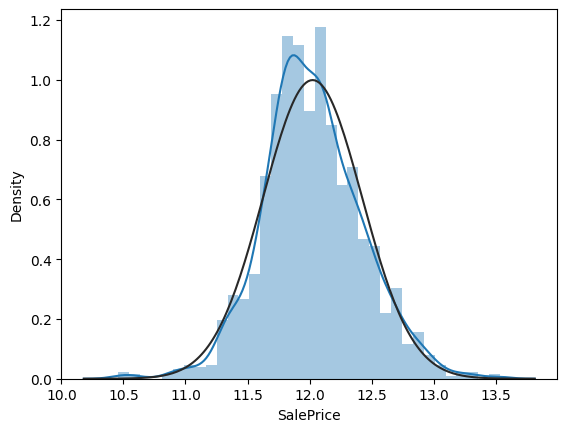

In [6]:
# target값을 로그 변환 후 SalePrice 값 분포도 확인

# np.log1p(house_df['SalePrice']) # 로그변환
sns.distplot(np.log1p(house_df['SalePrice']), fit=stats.norm)  # 정규분포랑 비교

### 데이터 확인 후 : 로그 변환 및 Null 처리
- 숫자형 피처에 대해 
    - Null이 너무 많은 피처는 삭제  
    - 기타 숫자형 Null값은 평균값으로 대체  

In [7]:
# SalePrice 로그 변환 df에 적용
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])
house_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016


In [8]:
# Null 이 너무 많은 피처와 불필요한 피처 삭제 
cols = ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']

for col in cols:
    house_df.drop(columns=col, inplace=True)

In [9]:
house_df.shape
# (1460, 74)

(1460, 74)

In [10]:
# 삭제하지 않은 수자형 Null 피처들은 평균값으로 대체
house_df.fillna(house_df.mean(numeric_only=True), inplace=True)
# mean() : 자동으로 숫자형 칼럼만 추출해서 칼럼별 평균값을 시리즈 객체로 반환
# 버전 변경 후 자동으로 안 됨 : numeric_only 설정 필요
# house_df.fillna(house_df.mean(numeric_only=True), inplace=True)

In [11]:
# Null 처리 후 확인 : Null 값이 있는 피처명과 타입 추출

null_counts = house_df.isnull().sum()[house_df.isnull().sum()>0]
house_df.dtypes[null_counts.index]
# obejct 형 변수에만 Null이 남고 나머지는 다 처리되었다.        

BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

### 카테고리 값의 문자열 변환
- ML 알고리즘에서 문자열 값을 입력 값으로 허용하지 않음
- 인코딩 처리하여 숫자형으로 변환


### 머신러닝의 대표적인 인코딩 방식
- 레이블 인코딩 (Label Encoding)
- 원-핫 인코딩 (One-Hot-Encoding)


In [12]:
# 원-핫 인코딩 수행 
print(' 원-핫 인코딩 수행 전 : ', house_df.shape)

# object 형 데이터 타입 컬럼들 따로 지정안해줘도 됨
# object_cols = house_df.select_dtypes(include=['object']).columns

# pandas get dummies로 원-핫 인코딩
# house_df = pd.get_dummies(house_df, columns=object_cols, dtype=float)
house_df_ohe = pd.get_dummies(house_df)
print(' 원-핫 인코딩 수행 후 : ', house_df_ohe.shape)

 원-핫 인코딩 수행 전 :  (1460, 74)
 원-핫 인코딩 수행 후 :  (1460, 267)


In [13]:
# Null 값을 가진 피처 확인
null_counts = house_df_ohe.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [14]:
house_df_ohe.info()
house_df_ohe.shape
# (1460, 74) -> (1460, 267)

# obejct형을 float으로 변경
# null값 처리 완료

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 267 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(230), float64(4), int64(33)
memory usage: 750.1 KB


(1460, 267)

### 전처리 작업 완료 
- 종속 변수는 로그 변환
- 결측값 1000 건 이상 피처는 삭제
- 나머지 숫자형 피처의 결측값은 평균값으로 대체
- 문자형 피처는 원-핫 인코딩 진행 

### 2. 선형 회귀 모델 : LinearRegression, Ridge, Lasso  

### (1) 학습/예측/평가

In [15]:
# 평가 함수 작성
# 학습된 모델을 받아서 예측하고 RMSE 반환
from sklearn.metrics import mean_squared_error, r2_score

# (1) 단일 모델의 RMSE 값 반환
def get_rmse(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    

    # 평가지표 출력
    print('{0} RMSE : {1:.3f}'.format(model.__class__.__name__, rmse)) # 모델 한개의 이름
    print('R제곱 : {0:.3f}'.format(r2_score(y_test, y_pred)))
    
    return rmse

# (2) 여러 모델의 RMSE 값 반환 : 1번 함수 호출
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
        
    return rmses     

In [16]:
# 데이터 준비
# 타깃
y_target = house_df_ohe['SalePrice']
# 피처
X_feature = house_df_ohe.drop('SalePrice', axis=1)

# 학습/테스트 데이터 세트 분리
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X_feature ,
                                                       y_target ,
                                                       test_size=0.3, 
                                                       random_state=156)

### 모델 생성/학습/예측/평가 

In [17]:
# 선형 계열 회귀 모델 생성/학습/예측
# linearRegression / Ridge / Lasso
from sklearn.linear_model import LinearRegression, Lasso, Ridge

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge = Ridge() # alpha는 설정 안하고 
ridge.fit(X_train, y_train)

lasso = Lasso() # alpha는 설정 안하고 
lasso.fit(X_train, y_train)

LinearRegression()

Ridge()

Lasso()

In [18]:
# 평가함수 호출 / 결과 출력
get_rmses([lr_reg, ridge, lasso])


# 결과 

# LinearRegression RMSE : 0.129 R제곱 : 0.894
# Ridge RMSE : 0.124 R제곱 : 0.902
# Lasso RMSE : 0.172 R제곱 : 0.813

# 3개 모델 전부 성능이 좋게 나왔음
# RMSE 수치는 Ridge가 가장 낮게 나왔고 Lasso가 가장 높게 출력됨
# Lasso가 타 회귀 모델보다 성능이 더 떨어지는 결과
# --> 추후 하이퍼 파라미터 튜닝을 진행해서 확인 필요
# --> 최적의 하이퍼 파라미터 찾고
# --> 릿지와 라쏘 모델에 대해 수행

# 먼저, 피처별 회귀 계수를 시각화 해서
# 모델별로 어떤 피처의 회귀 계수로 구성되는지 확인

LinearRegression RMSE : 0.129
R제곱 : 0.894
Ridge RMSE : 0.124
R제곱 : 0.902
Lasso RMSE : 0.172
R제곱 : 0.813


[0.12906403281496592, 0.12442517540185699, 0.17162071661564268]

### (2) 모델별 회귀 계수 시각화

In [19]:
# 피처 수가 많으므로 회귀 계수 값의
# 상위 10개, 하위 10개의 피처명과 회귀 계수값을 반환하는 함수 작성
def get_top_bottom_coef(model):
    # coef_속성을 기반으로 Series 객체 생성(회귀 계수와 피처명)
    # index는 피처명(컬럼명)
    coef = pd.Series(model.coef_, index=X_feature.columns)
    
    # + 상위 10개, - 하위 10개 회귀 계수 추출하여 반환
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    
    return coef_high, coef_low

In [20]:
# 모델별 회귀 계수 시각화하는 함수
# list 객체로 모델을 입력받아서
# 모델별 회귀 계수 상위 10개, 하위 10개 추출해서
# 가로 막대 그래프 형태 출력

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__ +' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120) # 안쪽, 패딩값
        
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

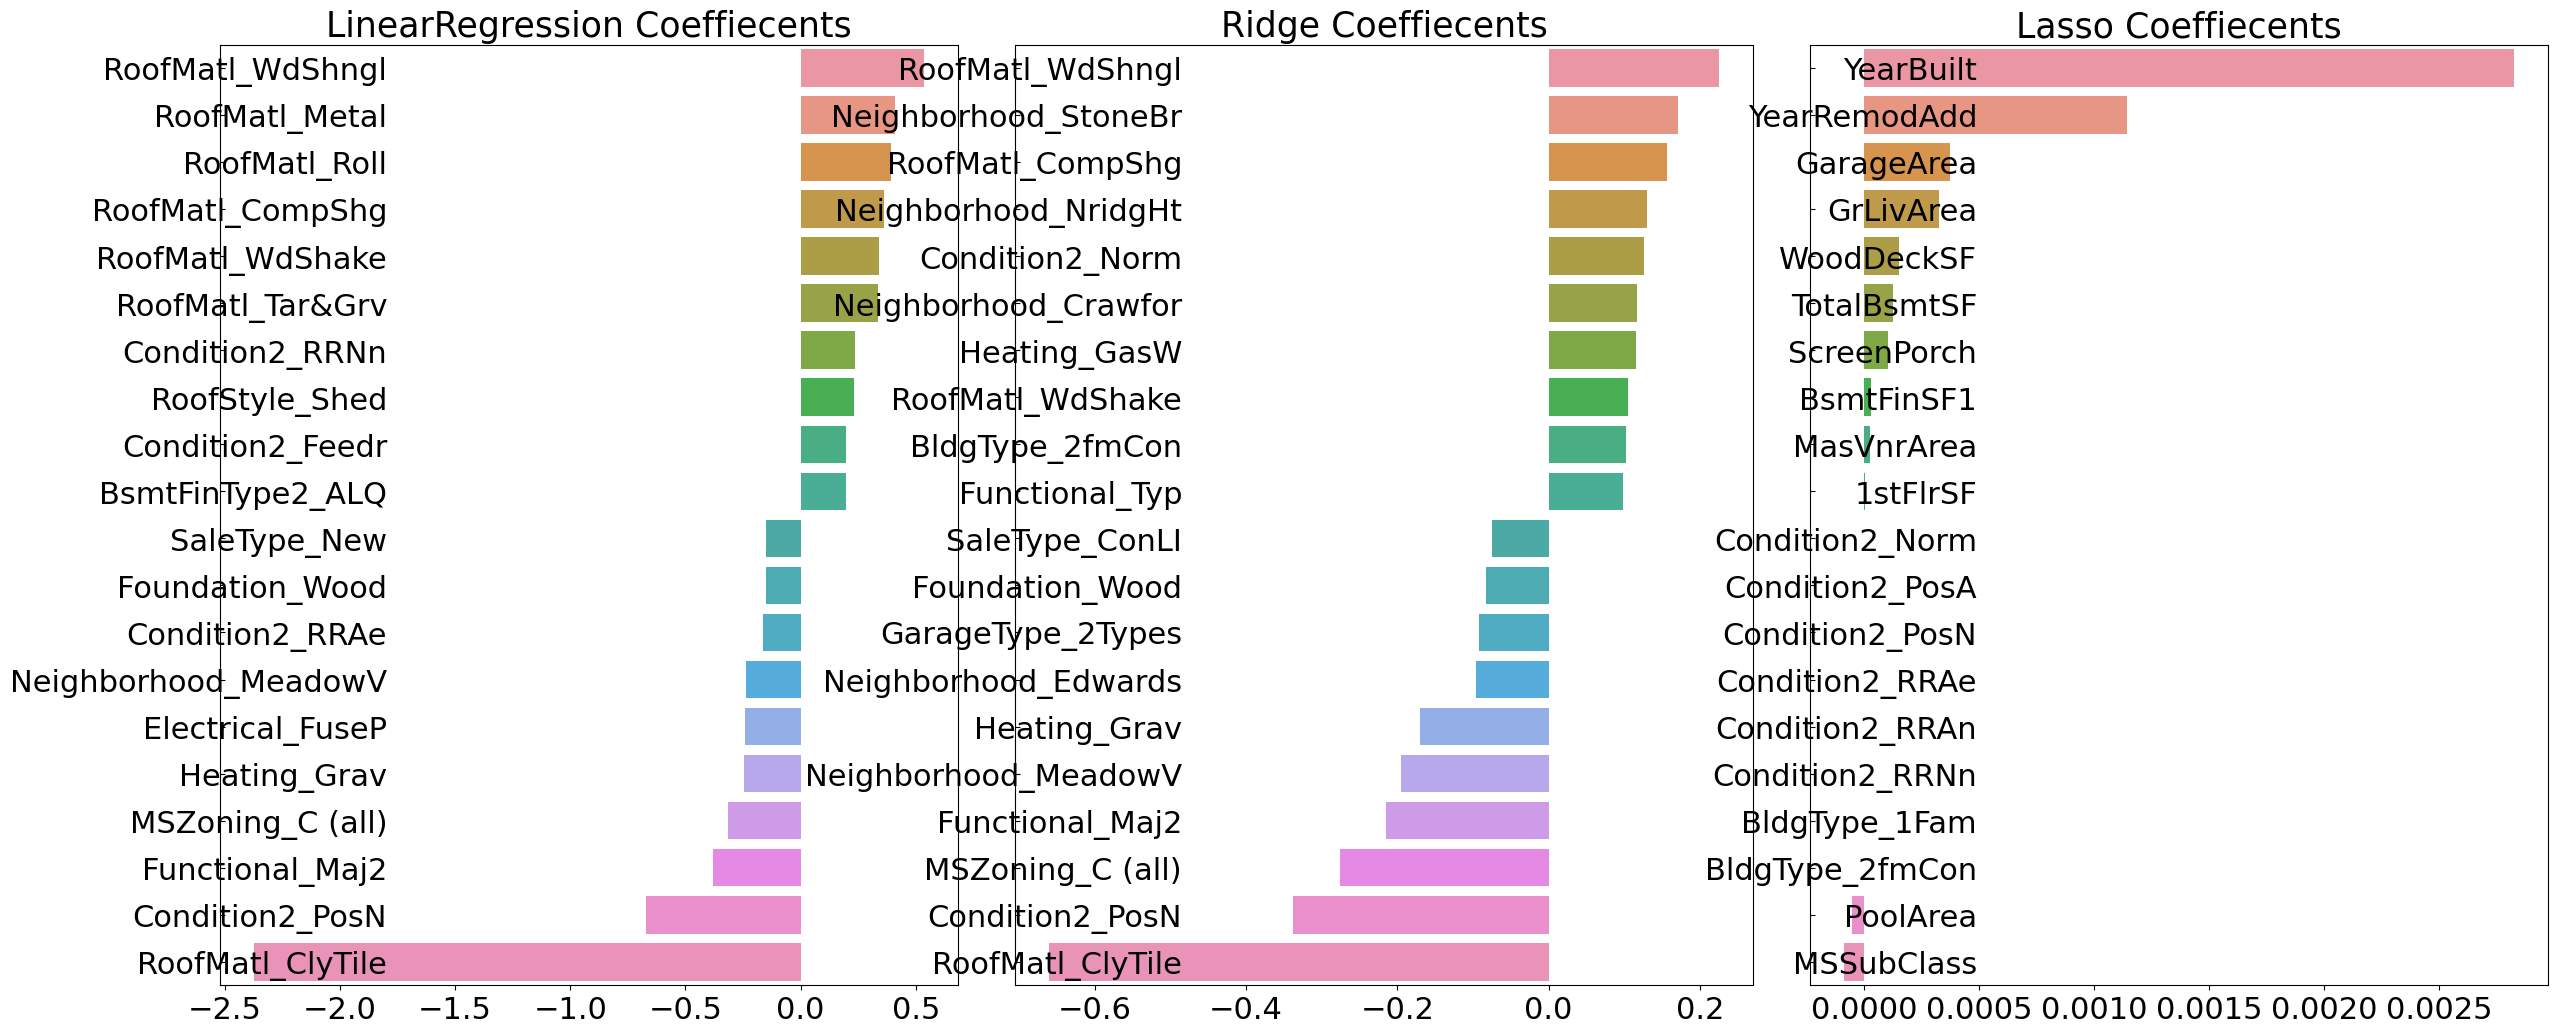

In [21]:
# 시각화 함수 호출 : 모델별 결과 출력
visualize_coefficient([lr_reg, ridge, lasso])

# 결과
# 각 모델별 상위, 하위 10개의 회귀 계수를 확인한 결과
# LinearRegression과 Ridge : 피처 종류와 회귀계수 유사

# Lasso : 전체적으로 피처종류도 차이가 있고, 회귀 계수 값이 매우 작음
# - YearBuilt가 가장 크고, 다른 피처와 회귀 계수는 너무 작음
# -> 혹시 학습 데이터 분할에 문제가 있어서 그런 것인지
# -> 교차검증을 진행하여 평균 RMSE 확인 필요

### (3) 교차 검증 수행

In [22]:
# 5개 폴드 교차 검증으로 모델별 RMSE와 평균 RMSE출력
from sklearn.model_selection import cross_val_score

# 교차검증 수행하는 함수 작성
def rmse_avvg_cv(models):
    # 5 Fold셋으로 MSE 구함
    # cross_val_score가 음수값으로 반환되므로 -1 곱해서 사용
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_feature, y_target,
                                    scoring='neg_mean_squared_error',
                                    cv=5))
        rmse_avg = np.mean(rmse_list)

        # 평가 지표 출력
        print('{0} 교차검증 RMSE : {1}'.format(model.__class__.__name__, rmse_list))
        print('{0} 교차검증 평균 RMSE : {1:.3f}'.format(model.__class__.__name__, rmse_avg))
    
    
# 함수 호출하고 회귀 모델 전달해서 결과 출력
rmse_avvg_cv([lr_reg, ridge, lasso])

# 교차검증 결과
# LinearRegression 평균 RMSE : 0.155
# Ridge 평균 RMSE : 0.144
# Lasso 평균 RMSE : 0.198

# 여전히 Lasso의 경우 LinearRegression과 Ridge모델 보다 성능이 약간 떨어짐
# --> 릿지, 라쏘 모델에 대해 alpha 하이퍼 파라미터 변화시키면서 최적값 도출해서 확인
# --> GridSearchCV 하이퍼 파라미터 튜닝 수행


# 교차검증 수행 전
# LinearRegression RMSE : 0.129 
# Ridge RMSE : 0.124 
# Lasso RMSE : 0.172

LinearRegression 교차검증 RMSE : [0.13490851 0.16426367 0.16637528 0.11076123 0.19760965]
LinearRegression 교차검증 평균 RMSE : 0.155
Ridge 교차검증 RMSE : [0.11733805 0.15411575 0.14184728 0.11638648 0.1886241 ]
Ridge 교차검증 평균 RMSE : 0.144
Lasso 교차검증 RMSE : [0.16077499 0.20437243 0.17676683 0.18127643 0.2651206 ]
Lasso 교차검증 평균 RMSE : 0.198


### (4) 하이퍼 파라미터 튜닝 후 재학습 / 예측 / 평가 

In [23]:
# Ridge 와 Lasso 모델의 Alpha값을 변화시키면서 hyper parameter 튜닝 수행 

In [66]:
from sklearn.model_selection import GridSearchCV

# 튜닝 수행 함수 작성
def get_best_params(model, params):
    # 최적 평균 RMSE 값 출력, 최적 alpha값
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error',
                             cv=5)
    grid_model.fit(X_feature, y_target)
    # 음수값으로 반환되므로 -1 곱해서 사용
    rmse = np.sqrt(-grid_model.best_score_)
    
    # 평가 지표 출력
    print('{0} 최적 평균 RMSE : {1:.4f}, 최적 alpha {2} '.format(model.__class__.__name__,
                                                              rmse,
                                                              grid_model.best_params_))
    return grid_model.best_estimator_
   
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}


get_best_params(ridge, ridge_params)
get_best_params(lasso, lasso_params)

# 결과
# Ridge 최적 평균 RMSE : 0.1417, 최적 alpha {'alpha': 10} 
# Lasso 최적 평균 RMSE : 0.1420, 최적 alpha {'alpha': 0.001} 

# GridSearchCV 적용 결과
# Ridge 모델 : 'alpha' 10에서 최적 평균 RMSE 0.1417
# Lasso 모델 :'alpha': 0.001에서 최적 평균 RMSE : 0.1420

# alpha값 튜닝 전
# Ridge : 평균 RMSE : 0.144
# Lasso : 평균 RMSE : 0.198

# Lasso 모델 : alpha 값 최적화 후 예측 성능이 많이 좋아짐 : 0.198 -> 0.142
# Ridge 모델 : 큰 차이는 없지만 조금이나마 성능이 향상됨 : 0.144 -> 0.1417

Ridge 최적 평균 RMSE : 0.1126, 최적 alpha {'alpha': 8} 


Ridge(alpha=8)

Lasso 최적 평균 RMSE : 0.1122, 최적 alpha {'alpha': 0.001} 


Lasso(alpha=0.001)

### 최적의 alpha 값으로 학습 / 예측 / 평가 

Ridge(alpha=10)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.475
R제곱 : -0.403
Ridge RMSE : 0.103
R제곱 : 0.934
Lasso RMSE : 0.100
R제곱 : 0.938


[0.47503253654591315, 0.10301715994244516, 0.10023723657391546]

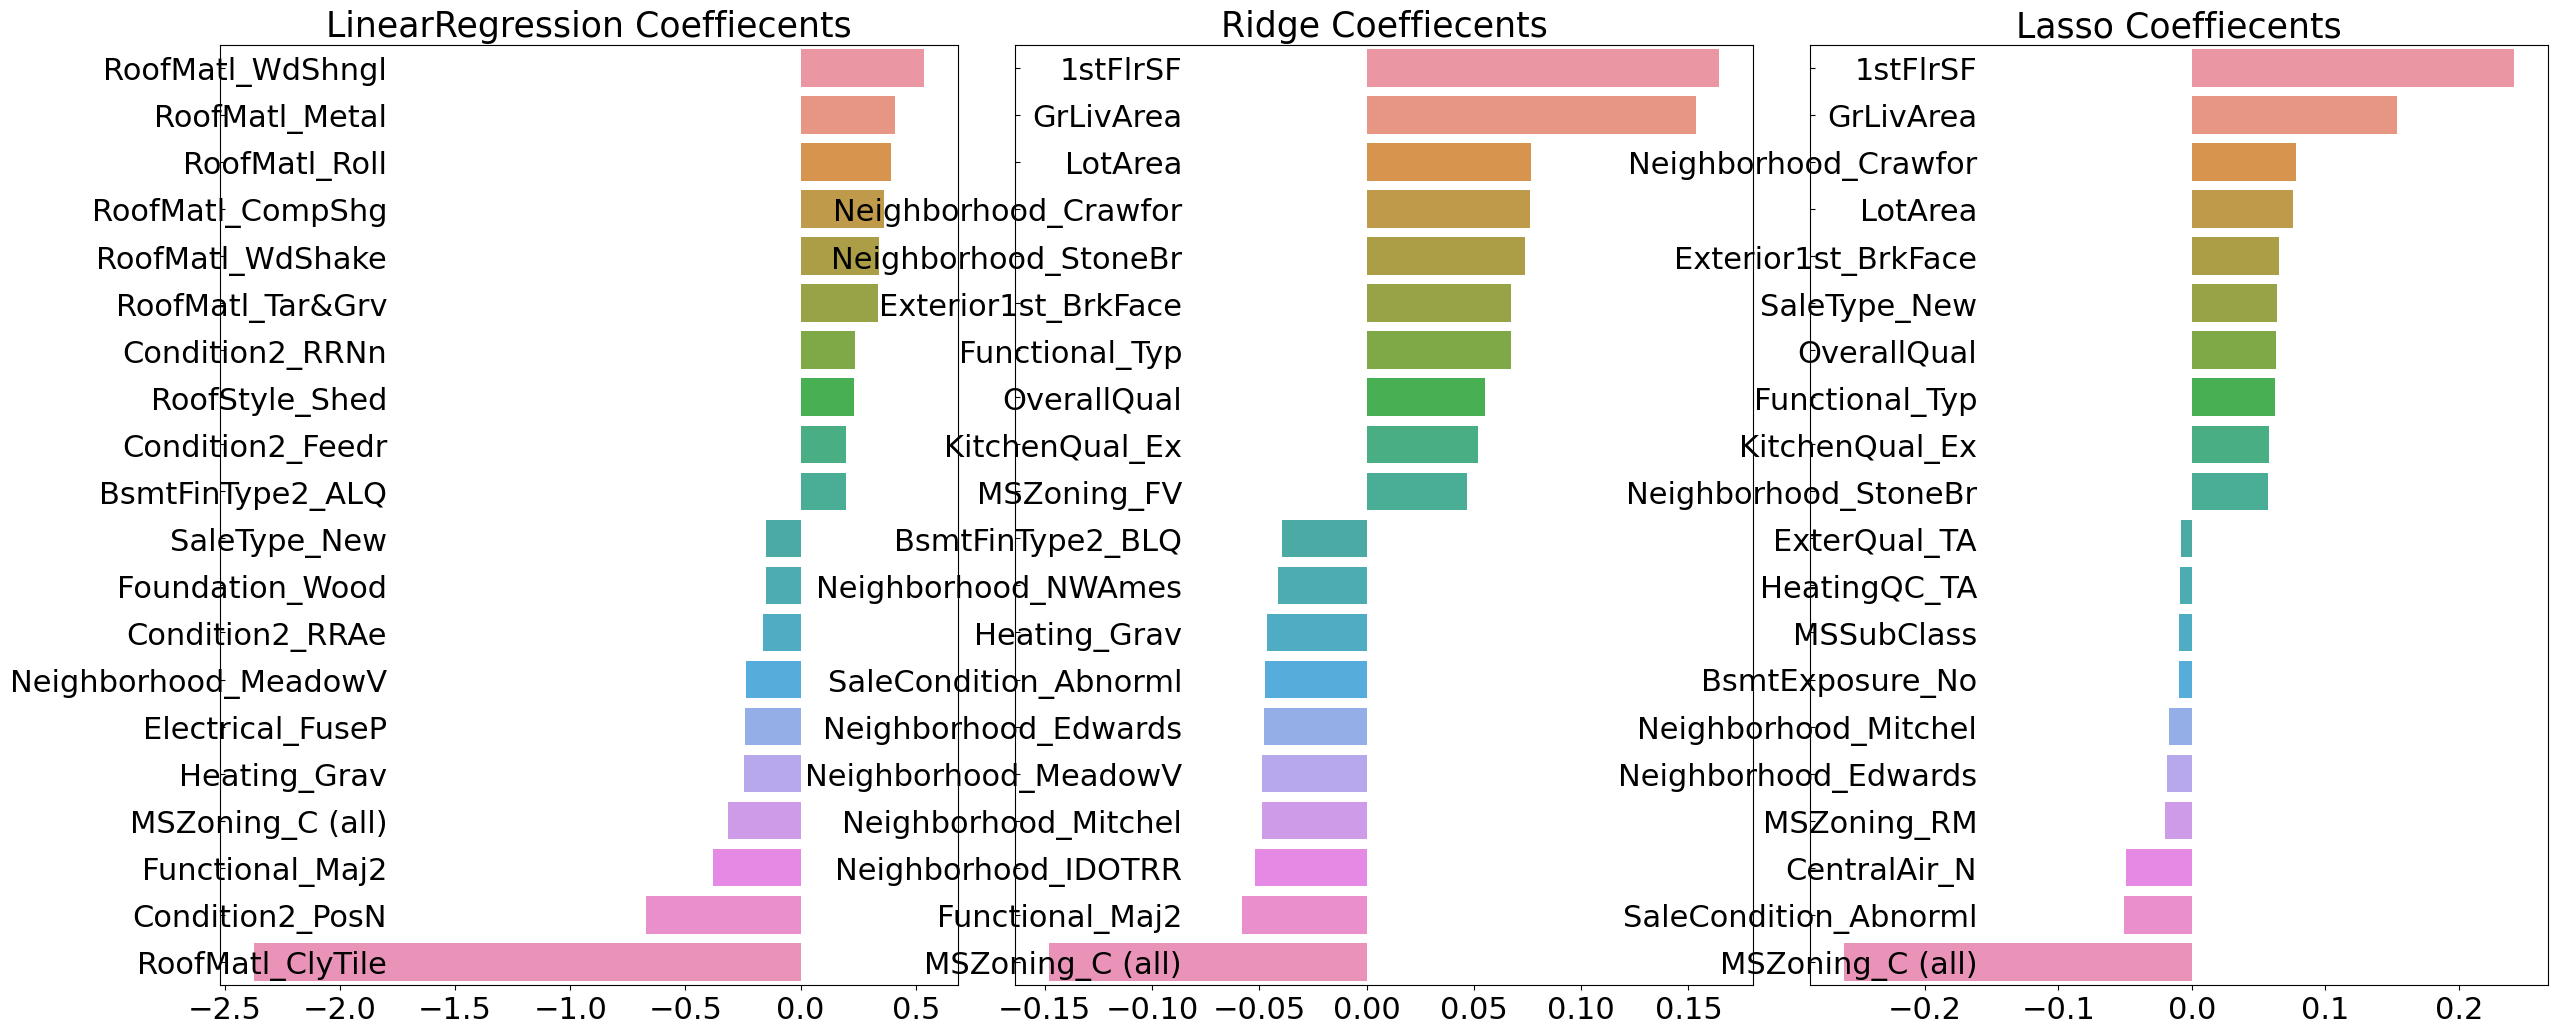

In [67]:
ridge = Ridge(alpha=10) # alpha는 설정 안하고 
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001) # alpha는 설정 안하고 
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])

# 결과
# LinearRegression RMSE : 0.129
# Ridge RMSE : 0.122
# Lasso RMSE : 0.117

# alpha 값 최적화 lasso의 경우 예측 성능이 더 좋아짐
# 회귀 계수 값도 상당히 작아졌고
# 앞에서는 라쏘가 상위, 하위 피처 종류에서도 차이가 많았음
# 지금 결과로는 릿지와 피처 종류도 어느 정도 유사해짐

# 결론
# 1차로 학습/예측/평가 했을 때 결과가 제일 안 좋았던 라쏘 모델이
# 교차검증과 하이퍼 파라미터 튜닝을 통해 성능이 많이 향상되었음을 확인할 수 있음

### 지금까지는 target 값에 대해서만 데이터 분포 확인하고 로그 변환 수행 

In [26]:
############################################################################

## 3. 피처 데이터 변환

### 추가 가공 작업 진행 후 모델 튜닝 좀 더 진행 
- (1) 피처 데이터 세트의 데이터 분포도 확인  
- (2) 이상치 데이터 처리

### (1) 피처 데이터 세트의 데이터 분포도 확인
- 앞에서 타깃 데이터(종속 변수) 세트의 데이터 분포도의 왜곡 확인했음
- 피처 데이터 세트의 경우도 지나치게 왜곡된 피처가 존재할 경우
- 회귀 예측 성능 저하 가능
- 모든 숫자형 피처의 데이터 분포도 확인해서 왜곡 정도 확인
- 왜곡도 높은 피처들은 로그 변환 수행


#### 왜곡된 정도 추출
- 사이파이 status 모듈의 skew() 함수 사용
    - 일반적으로 skew() 함수 반환 값이 1 이상인 경우 
    - 왜곡도가 높다고 판단  
- 주의 : 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 제외
    - 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높음

### (1) 왜곡도 / 피처 데이터 로그 변환 / 원-핫 인코딩
- 피처 중 왜곡도가 심한 피처를 로그 변환  

In [68]:
# 숫자형 피처들에 대한 데이터 분포 왜곡도 확인 후
# 높은 왜곡도를 나타내는 피처 추출하고
# 왜곡도 값이 1이상인 경우 높다고 판단
# 왜곡도 높은 피처들에 대해 log변환 적용

# 주의!
# 앞에서 one-hot encoding 적용된 house_df_ohe 데이터의
# 숫자형 피처들 중에는 문자형 피처가 one-hot encoding된 피처들이 포함되어 있음
# 숫자형 변수의 왜곡도 확인은
# one-hot encoding 적용 전 데이터인 house_df 사용

from scipy.stats import skew

# object가 아닌 숫자형 피처 index 추출
feature_index = house_df.dtypes[house_df.dtypes != 'object'].index


# skew()적용
# apply lambda로 skew()호출
skew_features = house_df[feature_index].apply(lambda x : skew(x))

# skew 정도가 1 이상인 피처들만 추출
skew_features_top = skew_features[skew_features > 1]
skew_features_top.sort_values(ascending=False)

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64

#### 로그 변환

In [69]:
# 왜곡도가 높은 피처들을 로그 변환
# skew 정도가 1이상인 피처들

house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [70]:
# 로그 변환 후 다시 왜곡 정도 확인
skew_features = house_df[feature_index].apply(lambda x : skew(x))

# skew 정도가 1 보다 큰 피처들만 추출
skew_features_top = skew_features[skew_features > 1]
skew_features_top.sort_values(ascending=False)

# 왜곡된 피처 수가 줄었지만
# 여전히 왜곡 정도가 높은 피처가 존재
# 더 이상 로그변환하더라도 개선되기 어렵다고 판단되면 이대로 유지하면서 진행

PoolArea         14.339852
3SsnPorch         7.638944
LowQualFinSF      7.330902
MiscVal           5.036720
BsmtHalfBath      3.888823
ScreenPorch       3.118480
KitchenAbvGr      2.954603
BsmtFinSF2        2.446157
EnclosedPorch     2.062641
dtype: float64

### (2) 모델 학습/예측/평가
- 원-핫 인코딩 적용 후 최적 하이퍼 파라미터 튜닝 후 평가 지표 확인

In [71]:
# skew가 높은 피처들을 로그 변환했으므로
# 다시 원-핫 인코딩 적용
# 피처/타깃 데이터 세트 다시 생성
# 최적 alpha 값과  RMSE 출력


# 원-핫 인코딩
house_df_ohe2 = pd.get_dummies(house_df)

# 티킷/피처 데이터 세트 생성
y_target = house_df_ohe2['SalePrice']
X_feature = house_df_ohe2.drop('SalePrice', axis=1)

In [72]:
# 학습/테스트용 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_feature ,
                                                       y_target ,
                                                       test_size=0.2, 
                                                       random_state=156)

# 다시 최적 하이퍼 파라미터 튜닝 후 RMSE 출력 
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

get_best_params(ridge, ridge_params)
get_best_params(lasso, lasso_params)

# 결과
# 피처 데이터 로그변환 전
# GridSearchCV 적용 결과
# Ridge모델 : 'alpha' : 10에서 최적평균 RMSE : 0.1417
# Lasso모델 : 'alpha' 0.001에서 최적 평균 RMSE : 0.1420

# 피처 데이터 로그변환 후
# Ridge모델 : 'alpha' : 10에서 최적평균 RMSE : 0.1275
# Lasso모델 : 'alpha' 0.001에서 최적 평균 RMSE : 0.1252

# 피처 데이터 로그변환후
# 릿지와 라쏘 모두 약간의 성능이 향상되었음

Ridge 최적 평균 RMSE : 0.1275, 최적 alpha {'alpha': 10} 


Ridge(alpha=10)

Lasso 최적 평균 RMSE : 0.1251, 최적 alpha {'alpha': 0.001} 


Lasso(alpha=0.001)

### (3) 모델별 회귀 계수 시각화  
- 모델의 학습/예측/평가 및 모델별 회귀 계수 시각화

Ridge(alpha=10)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.479
R제곱 : -0.383
Ridge RMSE : 0.121
R제곱 : 0.911
Lasso RMSE : 0.117
R제곱 : 0.917


[0.4792115005199718, 0.12146570507673364, 0.11720031635164756]

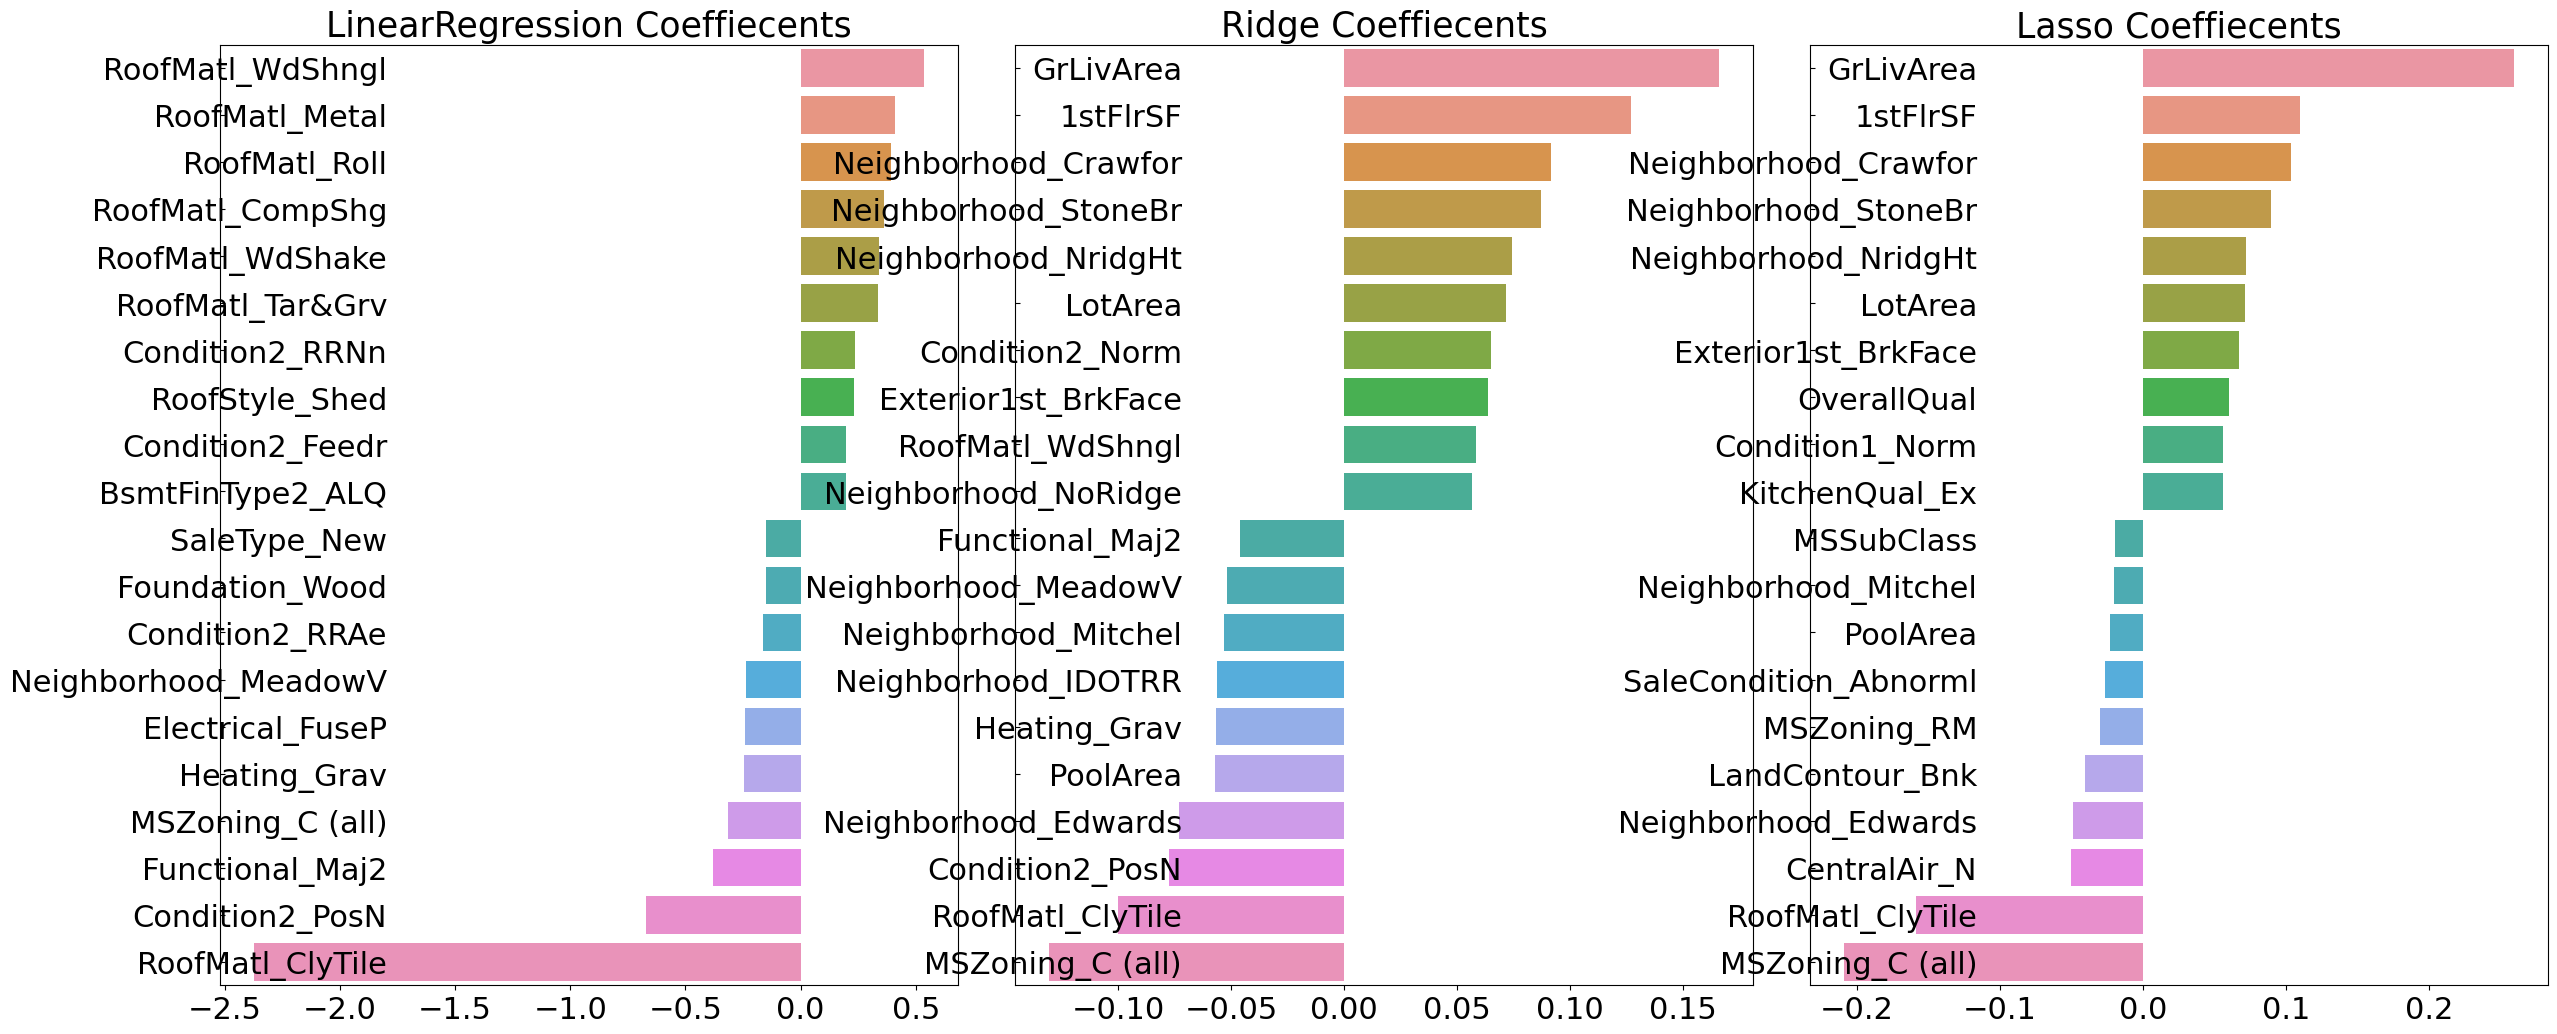

In [73]:
# 최적화 alpha값으로 학습/예측/평가 수행
ridge = Ridge(alpha=10) 
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001) 
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])


# skew가 높은 피처들을 로그변환 후 결과

# ridge lasso모델은 RMSE 수치가 약간 향상되었고
# R제곱 수치도 좋음

# 릿지 모델 : alpha=10에서 최적 평균 RMSE : 0.122 -> 0.122
# 라쏘 모델 : alpha=0.001에서 최적 평균 RMSE :0.117 -> 0.119

# LinearRegression은 RMSE수치가 많이 올라갔고
# R제곱이 음수로 과적합으로 인한 오차가 발생했음 확인
# LinearRegression RMSE : 0.129 -> 0.484
# R제곱 : -0.381


##--------------------------------------
# 회귀 계수 확인
# 릿지와 라쏘 모델 모두 GrLiveArea(주거 공간 크기) 피처가 
# 회귀 계수가 가장 높은 피처로 나타났고
# - 즉, 주거공간의 크기가 가격에 미치는 영향이 가장 높다는 의미로
# - 이제서야 상직적으로 생각할 수 있는 결론 도출됨

# 또한 회귀 계수가 상위 피처들이 유사한 피처들로 나타났음
# - 지금까지 만든 모델의 성능이 우수하다고 판단됨

### (4) 이상치 데이터 처리

다음으로 좀 더 분석할 요소는 이상치 데이터  
특히 회귀 계수가 높은 피처들은  
예측에 많은 영향을 미치는 중요 피처들이기 때문에  
이들 피처들의 이상치 데이터 처리가 중요함  

먼저 3개 모델 모두에서 가장 큰 회귀 계수를 가지는  
GrLivArea(주거 공간 크기) 피처의 데이터 분포 살펴 볼 것임

Text(0, 0.5, 'SalePrice')

Text(0.5, 0, 'GrLivArea')

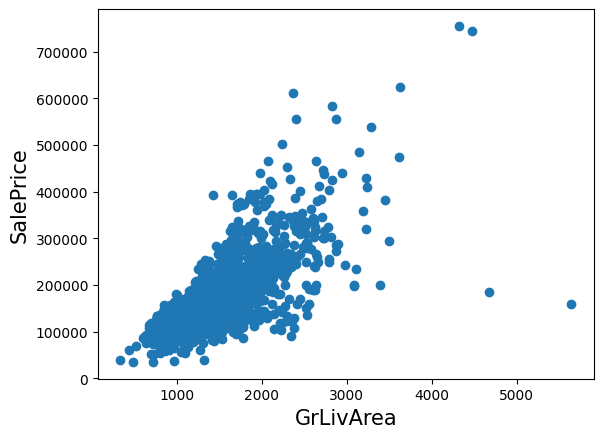

In [74]:
# 이상치 데이터 검출을 위해 주요 피처인 GrLivArea(주거 공간 크기) 값에 대한 산포도 확인
# 주택 가격 데이터가 변환되기 이전의 원본 데이터 세트에서
# GrLivArea(주거 공간 크기) 와 타깃 값인 SalePrice의 관계 시각화
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)

# 오른쪽 아래 2개의 데이터를 이상치로 간주
# 크기는 제일 큰데 가격은 상당히 저렴
# 이상치로 간주하고 삭제
# 이상치 기준은 GrLiveArea(크기)는 4,000 이상인데, SalePrice가 500,000이하일때

Text(0, 0.5, 'SalePrice')

Text(0.5, 0, 'GrLivArea')

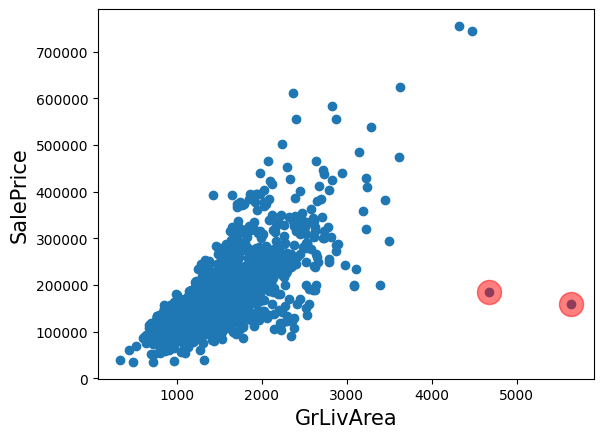

In [75]:
# 그래프에 확인한 이상치 표시
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)

outlier = (house_df_org["GrLivArea"] > 4000) & (house_df_org["SalePrice"] < 500000)
outlier_df = house_df_org[outlier]
plt.scatter(x=outlier_df["GrLivArea"] , y=outlier_df["SalePrice"], s=300, c="r", alpha=0.5 )

plt.show()

In [76]:
# 이상치 조건에 따라 이상치 제거
# 크기 4000보다 크고 SalePrice 500000 이하


# 주의! 지금 사용하는 데이터는 house_df_ohe2(로그 변환된 데이터)
# 4000과 500000도 로그변환해서 비교
cond1 = house_df_ohe2["GrLivArea"] > np.log1p(4000)
cond2 = house_df_ohe2["SalePrice"] <= np.log1p(500000)
outlier_index = house_df_ohe2[cond1 & cond2].index

print('이상치 삭제전 :', house_df_ohe2.shape)

# 이상치 삭제
house_df_ohe2.drop(outlier_index, axis=0, inplace=True) 

print('이상치 삭제후 :', house_df_ohe2.shape)

이상치 삭제전 : (1460, 267)
이상치 삭제후 : (1458, 267)


### (5) 릿지 / 라쏘 모델 최적화 수행 

In [77]:
# 티킷/피처 데이터 세트 생성
y_target = house_df_ohe2['SalePrice']
X_feature = house_df_ohe2.drop('SalePrice', axis=1)

# 학습/테스트용 데이터 세트 분리
X_train , X_test , y_train , y_test = train_test_split(X_feature ,
                                                       y_target ,
                                                       test_size=0.2, 
                                                       random_state=156)

# 다시 최적 하이퍼 파라미터 튜닝 후 RMSE 출력 
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

get_best_params(ridge, ridge_params)
get_best_params(lasso, lasso_params)



# 이상치 제거 전
# Ridge 최적 평균 RMSE : 0.1275, 최적 alpha 10
# Lasso 최적 평균 RMSE : 0.1252, 최적 alpha 0.001


# 이상치 제거 후
# Ridge 최적 평균 RMSE : 0.1126, 최적 alpha  8
# Lasso 최적 평균 RMSE : 0.1122, 최적 alpha  0.001

# 2개의 이상치 데이터만 제거했는데 예측 수치가 약간 상승되었음
# 두 모델 모두 개선되었음을 확인
# 최적의 alpha값 확인 -> 재학습/평가 수행

Ridge 최적 평균 RMSE : 0.1126, 최적 alpha {'alpha': 8} 


Ridge(alpha=8)

Lasso 최적 평균 RMSE : 0.1122, 최적 alpha {'alpha': 0.001} 


Lasso(alpha=0.001)

Ridge(alpha=8)

Lasso(alpha=0.001)

LinearRegression RMSE : 0.470
R제곱 : -0.372
Ridge RMSE : 0.103
R제곱 : 0.934
Lasso RMSE : 0.100
R제곱 : 0.938


[0.4697796917786563, 0.1030242603121477, 0.09991870258961681]

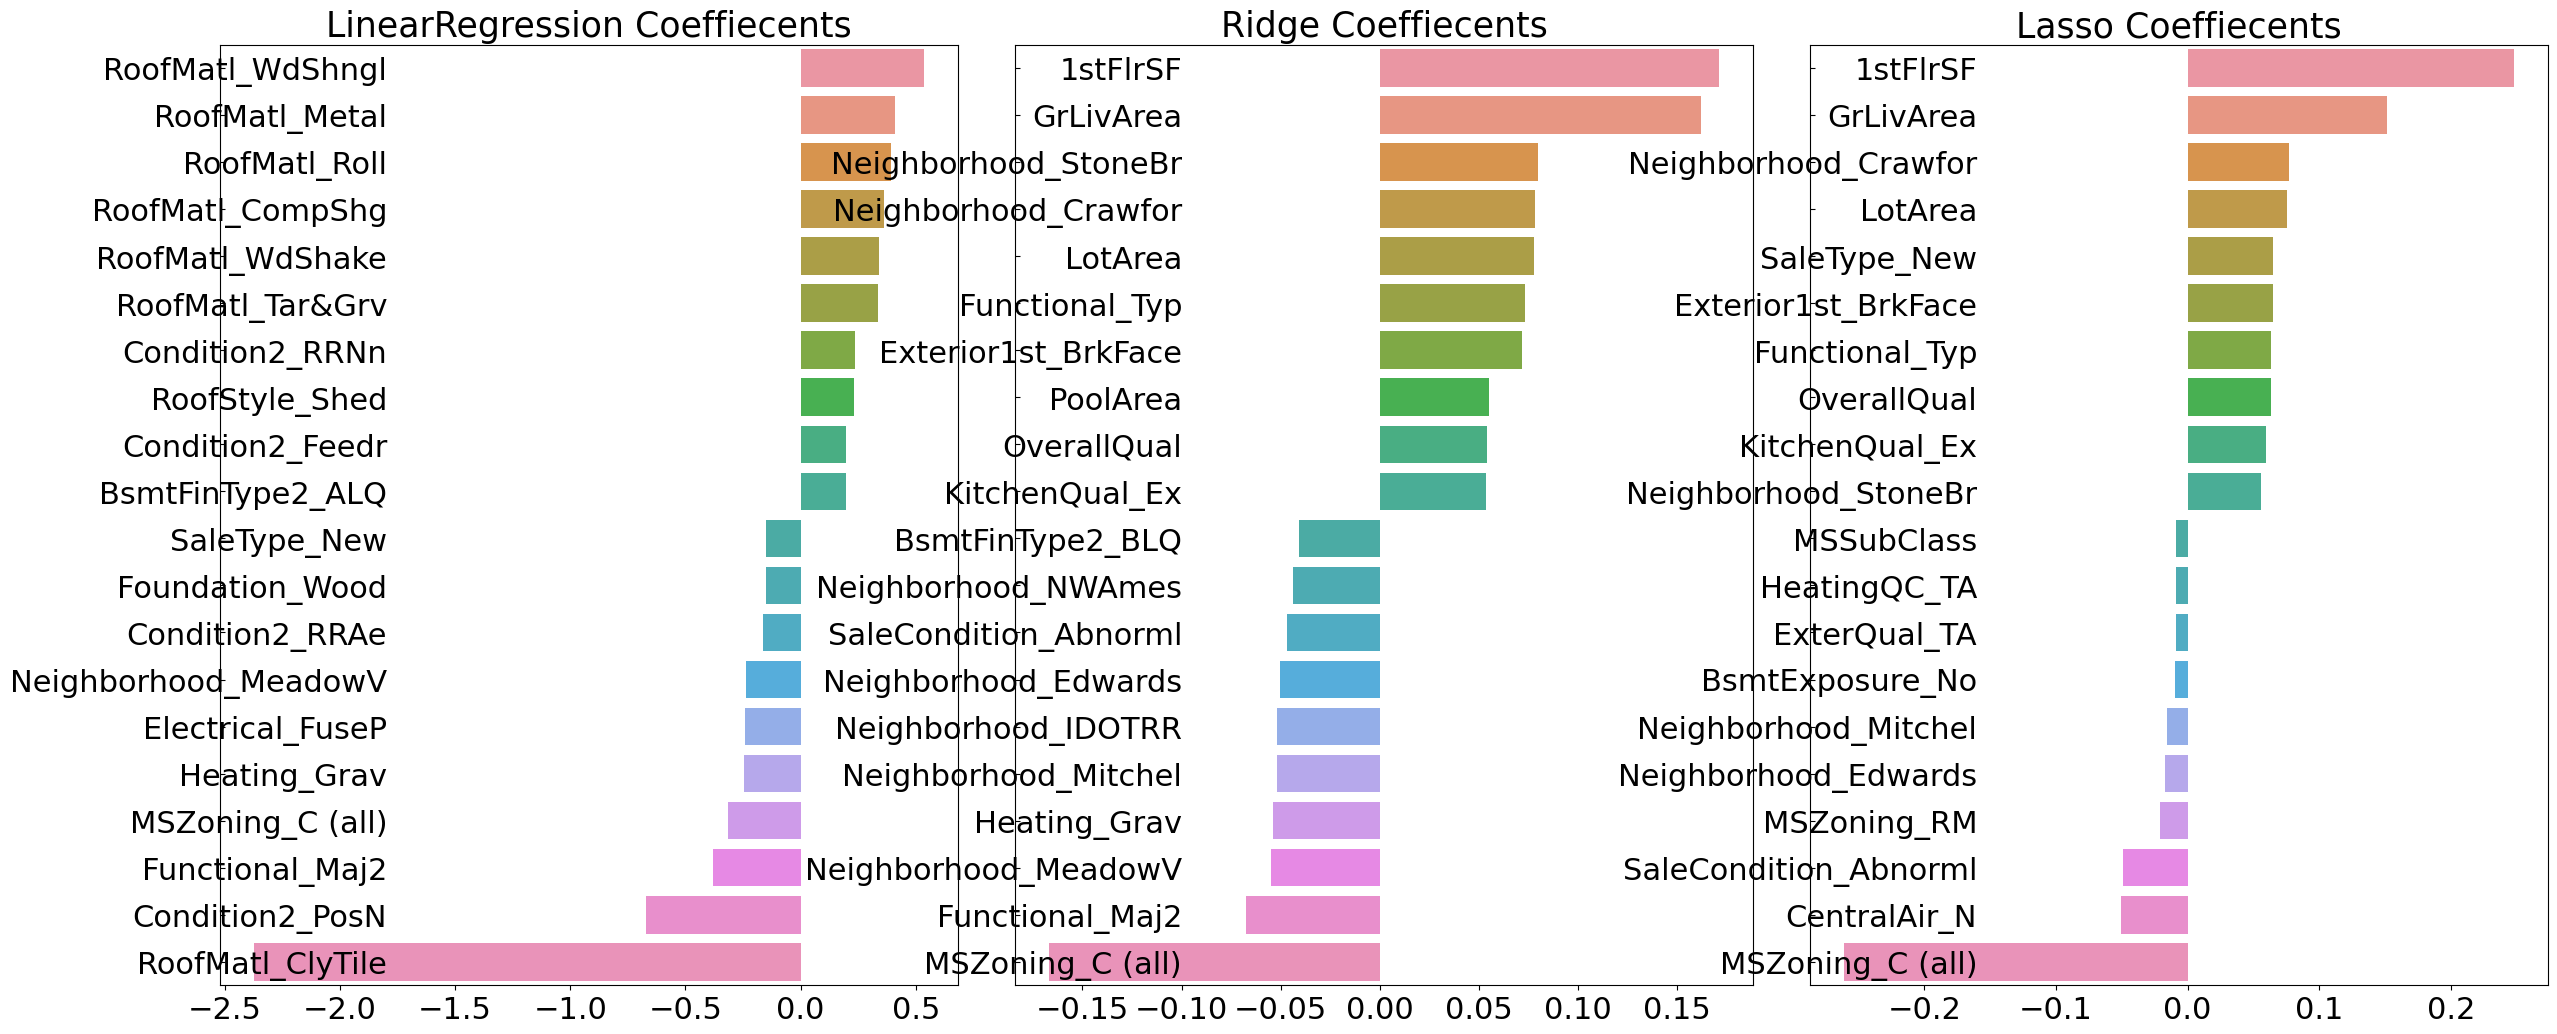

In [78]:
# 최적화 alpha값으로 학습/예측/평가 수행
ridge = Ridge(alpha=8) 
ridge.fit(X_train, y_train)

lasso = Lasso(alpha=0.001) 
lasso.fit(X_train, y_train)

# 모든 모델의 RMSE출력
get_rmses([lr_reg, ridge, lasso])

# 모든 모델의 회귀 계수 시각화
visualize_coefficient([lr_reg, ridge, lasso])


# 최종 결과
# Ridge RMSE : 0.103 R제곱 : 0.934
# Lasso RMSE : 0.100 R제곱 : 0.938

# ridge와 lasso모델 모두 지금까지 결과 중 가장 좋게 나타났음
# 특히 lasso모델이 많이 향상되었음을 확인

# 결론
# 이상치 데이터를 제거한 후 예측 수치가 향상된 것을 확인
# GrLiveArea 피처가 현 회귀 모델에서 차지하는 영향도가 크기 때문에
# - 이상치를 제거함으로써 성능 개선에 도움이 되었음

# 회귀에서는 중요한 영향을 미치는 피처를 위주로
# - 이상치 데이터를 찾으면 성능 개선 효과가 큼

### tip
- 일반적로 머신러닝 프로세스에서 데이터 전처리는 알고리즘 적용 전에 진행하지만    
- 처음부터 완벽하게 수행할 필요는 없음    
- 대략의 데이터 가공을 진행하고 모델 최적화를 진행한 후    
- 결과를 기반으로 다시 여러 가지 전처리 작업을 진행하는 것이 바람직함  

In [ ]:
##################################################################

### 4. 회귀 트리 모델  : XGBoost와 LightGBM

선형 회귀
- 회귀 계수를 선형으로 결합하는 회귀 함수를 구해
- 여기에 독립변수를 입력해 결과값을 예측하는 것

비선형 회귀
- 비선형 회귀 함수를 통해 결과값을 예측

머신러닝 기반의 회귀
- 회귀 계수를 기반으로 하는 최적화 회구 함수를 도출하는 것이 목표

회귀 트리
- 회귀 함수를 기반으로 하지 않고
- 트리를 기반으로 하는 회귀 방식
- 분류 트리와 유사하지만
- 리프 노드에서 예측 결정값을 만든 과정에 차이가 있음
- 분류 트리 : 특정 클래스 레이블 결정
- 회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값 계산
    
CART(Classification And Regression Trees) 기반 알고리즘
- 결정트리, 랜덤 포레트스, GBM, XGBoost, LightGBM 등 트리 기반 알고리즘은
- 분류뿐만 아니라 회귀도 가능

### (1) 회귀 트리 모델 생성/학습/예측/평가   
- XGBoost와 LightGBM 이용해서 학습/예측/평가 수행

In [50]:
# XGBoost와 LightGBM은 분류 수행할 때 수행 속도가 상당히 빠르다는 것을 확인 했지만
# 환경에 따라 수행시간이 오래 걸릴 수 있으므로
# 하이퍼 파라미터 설정을 미리 적용한 상태로
# 5폴드 세트에 대한 평균 RMSE 값 추출 

In [79]:
# XGBoost 회귀 트리 적용

from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}

xgb_reg = XGBRegressor(object='reg:squarederror',
                      n_estimators=1000,
                      learning_rate=0.05,
                      colsample_bytree=0.5,
                      subsample=0.8
                      )

best_xgb = get_best_params(xgb_reg, xgb_params)

# colsample_bytree = 0.5
# - 각 트리(스텝)마다 사용할 피처 샘플링 비율 (0.5~1) (랜덤 샘플)
# - 일부만 샘플링해서 과적합 방지

# subsample=0.8
# -각 스텝마다 사용할 학습 데이터의 서브 샘플 비율
# 트리 성장 전 학습 데이터와 일부만 샘플링해서 과적합 방지

# XGBRegressor 적용 시
# 최적 평균 RMSE : 0.1222, 최적 alpha {'n_estimators': 1000} 

XGBRegressor 최적 평균 RMSE : 0.1222, 최적 alpha {'n_estimators': 1000} 


In [80]:
# LightGBM 회귀 트리 적용

from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,
                        learning_rate=0.05,
                        num_leaves = 4, # 하나의 트리가 가질 수 있는 최대 리프 수
                        colsample_bytree=0.5,
                        subsample=0.6,
                        reg_lambda=10, # L2규제 적용값,
                        force_row_wise=True
                        )

best_lgbm = get_best_params(lgbm_reg, lgbm_params)
# LGBMRegressor 회귀 트리 적용 시 
# 5 폴드 세트 평균 RMSE : 0.1166 (colsample_bytree=0.4)
# 5 폴드 세트 평균 RMSE : 0.1170 (colsample_bytree=0.5)

# XGBMRegressor 적용시
# 5 폴드 세트 평균 RMSE : 0.1222

# LGBMRegressor가 XGBMRegressor보다 약간 수치 향상 있음

LGBMRegressor 최적 평균 RMSE : 0.1170, 최적 alpha {'n_estimators': 1000} 


### (2) 피처 중요도 시각화  
- 트리 회귀 모델의 피처 중요도 시각화

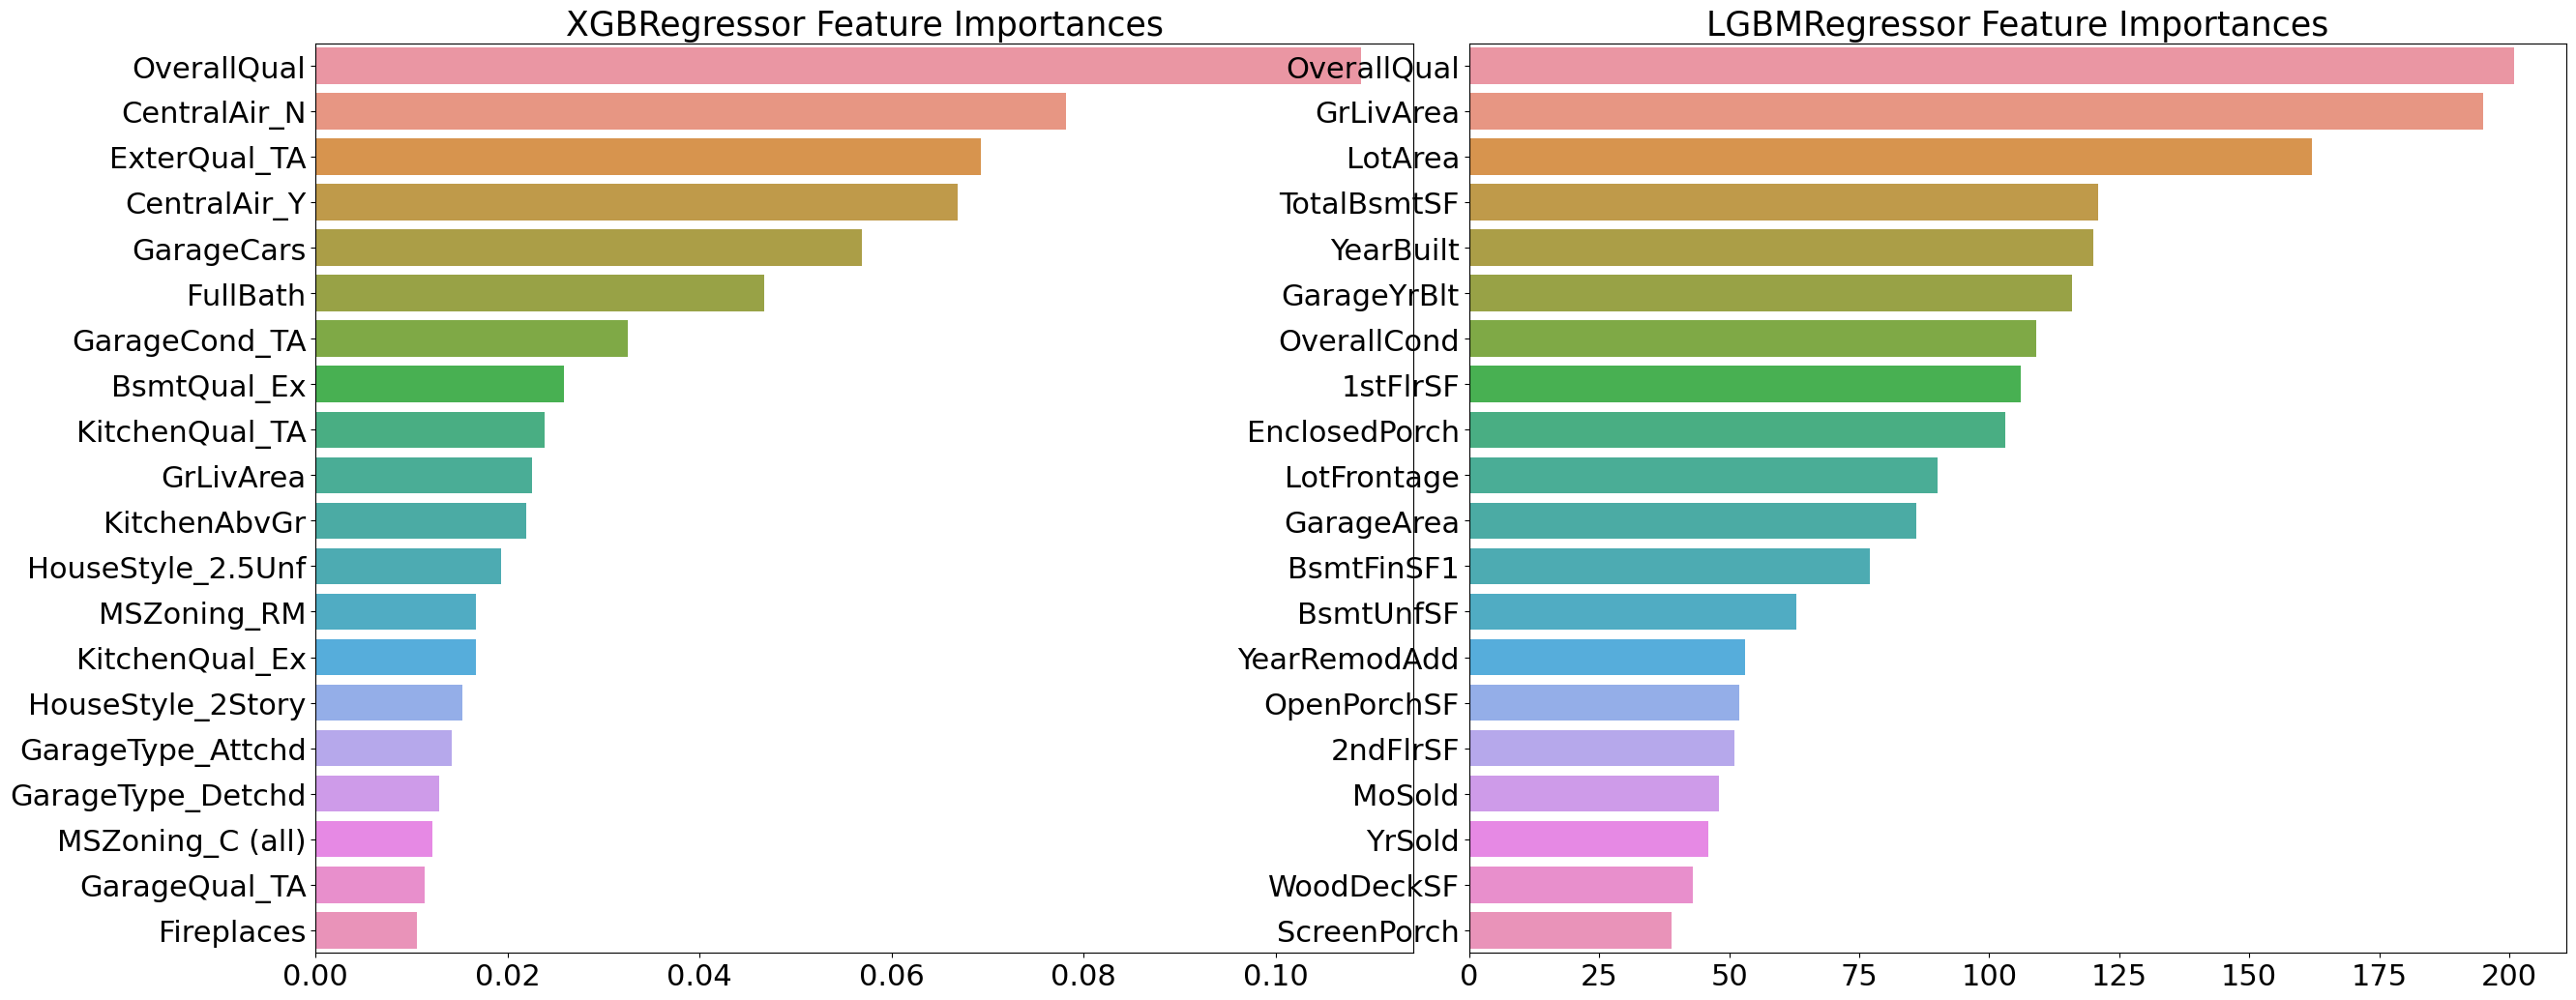

In [83]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_feature.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 시각화
visualize_ftr_importances([best_xgb, best_lgbm])

In [ ]:
######################################################

### 5. 회귀 모델의 예측 결과 혼합을 통한 최종 예측
-   릿지 모델(40%)과 라쏘 모델(60%) 혼합 

개별 회귀 모델의 예측 결과값을 혼합해서 (4개)
이를 기반으로 최종 회귀 값 예측  

예측 결과 혼합 예  
A 모델 , B 모델  
A 모델의 예측값 40%, B 모델의 예측값의 60%를 더해서 최종 회귀값으로 예측  

A :[100, 80, 60]  , B : [120, 80, 50]  
[100*0.4 + 120*0.6, 80*0.4 + 80*0.6, 60*0.4 + 50*0.6]

In [61]:
# 앞에서 진행한 릿지 모델(40%)과 라쏘 모델(60%) 혼합
# 개별 모델과 최종 혼합 모델의 RMSE 확인

# 모델의 RMSE 값 출력하는 함수 작성
def get_rmse_pred(preds):
    for key in preds.keys():
        y_pred = preds[key]
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE : {1:.4f}'.format(key, rmse))

In [63]:
# 개별 모델 학습

ridge_reg = Ridge(alpha=8) # 앞에서 수행한 결과 최적의 alpha=8 사용
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_y_pred = ridge_reg.predict(X_test)
lasso_y_pred = lasso_reg.predict(X_test)

# 혼합 모델
# 개별 모델 예측값 혼합으로 최종 예측값 도출
y_pred = 0.2 * ridge_y_pred + 0.8 * lasso_y_pred

# 평가 함수 호출
y_preds = {
    '최종 혼합' : y_pred,
    'Ridge' : ridge_y_pred,
    'Lasso' : lasso_y_pred
}

# 모델들의 RMSE 값 출력
get_rmse_pred(y_preds)


# 릿지(40%) + 라쏘(60%)
# 최종 혼합 모델의 RMSE : 0.1000
# Ridge 모델의 RMSE : 0.1033
# Lasso 모델의 RMSE : 0.1002

# 릿지(20%) + 라쏘(80%)
# 최종 혼합 모델의 RMSE : 0.0999
# Ridge 모델의 RMSE : 0.1033
# Lasso 모델의 RMSE : 0.1002

# 결과
# 최종 혼합 모델의 RMSE가 개별 모델보다 성능면에서 약간 개선됨
# 지금까지 봤던 수치 중 가장 좋은 수치 :rmse 0.0999 (릿지(20%) + 라쏘(80%))
# 릿지 모델과  라쏘 모델의 혼합 비율을 정하는 특별한 기준은 없음
# 두 개 모델 중 성능이 약간 좋은 쪽에 가중치를 더 두면 성능이 더 향상됨을 볼 수 있음

# 지금까지 적용한 모델 중
# 혼합 모델의 경우가 성능이 가장 좋게 나왔음

Ridge(alpha=8)

Lasso(alpha=0.001)

최종 혼합 모델의 RMSE : 0.0999
Ridge 모델의 RMSE : 0.1033
Lasso 모델의 RMSE : 0.1002


In [ ]:
######################################################################

### 6. 스태킹 앙상블 모델을 통한 회귀 예측 

스태킹 모델을 회귀에도 적용

스태킹(Stacking)
- 개별적인 여러 알고리즘을 서로 결합해서 예측 결과를 도출한다는 점에서는
- 배깅 및 부스팅 방식과 동일하지만
- 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로
- 다시 예측을 수행하는 것

(1) 개별 알고리즘의 예측 결과 데이터 세트를  
(2) 최종적인 메타 데이터 세트로 만들어  
(3) 별도의 ML 알고리즘으로 최종 학습을 수행하고  
(4) 테스트 데이터를 기반으로다시 최종 예측을 수행하는 방식  

메타 모델
- 개별 모델의 예측된 데이터 세트를 기반으로
- 다시 학습하고 예측하는 방식

스태킹 모델의 구현 방법 정리
- 두 종류의 모델 필요  
(1) 개별적인 기반 모델  
(2) 개별 기반 모델의 예측 데이터를 학습 데이터로 학습하는 최종 메타 모델  

스태킹 모델의 핵심
- 여러 개별 모델의 예측 데이터를  
- 각각 스태킹 형태로 결합해  
- 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것  

최종 메타 모델이 학습할 피처 데이터 세트  
- 원본 학습 피처 데이터 세트로 학습한 개별 모델의 예측값을  
- 스태킹 형태로 결합한 것  

In [85]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습/테스트용 데이터 세트를 생성하기 위한 함수
# 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서
# 원본 학습 데이터를 다시 추출해서 학습/예측 수행한 뒤 결과 저장
# --> 추후 메타 모델의 학습 피처 데이터 세트로 이용

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')   
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, 
    # test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


In [86]:
# 4개의 모델에 대해 train, test 메타 데이터 생성
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반 모델이 생성한 학습용/테스트용 데이터 반환 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [88]:
# 최종 메타 데이터 결합 
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  

Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train),
                                     axis=1)

Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test),
                                     axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.005)

# 기반 모델의 예측값을 기반으로 새롭게 만들어진
# 학습/테스트 데이터로 학습/예측하고 평가 RMSE 확인
meta_model_lasso.fit(Stack_final_X_train, y_train)
final_y_pred = meta_model_lasso.predict(Stack_final_X_test)

# 평가
mse = mean_squared_error(y_test, final_y_pred)
rmse = np.sqrt(mse)

print('스태킹 회귀 모델의 최종 RMSE: ', rmse)

# 릿지(20%) + 라쏘(80%) 혼합 모델 RMSE : 0.0999
# 스태킹 회귀 모델의 최종 RMSE:  0.0971093880796617

# 스태킹 모델의 RMSE 수치가 약간 더 좋음
# 현재까지 가장 좋은 성능 평가로 보여짐

Lasso(alpha=0.005)

스태킹 회귀 모델의 최종 RMSE:  0.0971093880796617
